In [1]:
import numpy as np
import scipy
import pandas as pd
import torch
from datetime import datetime, timedelta
from scipy.stats import qmc
from bo_methods_lib.bo_functions_generic import round_time, gen_theta_set,gen_x_set, find_train_doc_path, set_ep, clean_1D_arrays
# from bo_methods_lib.GP_Vs_True import Muller_plotter
from bo_methods_lib.GP_Vs_True_Sensitivity import Muller_plotter
# from .CS1_create_data import gen_y_Theta_GP, calc_y_exp, create_y_data
from bo_methods_lib.CS2_create_data import gen_y_Theta_GP, calc_y_exp, create_y_data

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern

/afs/crc.nd.edu/user/m/mcarlozo/.conda/envs/Toy_Problem_env/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#Set Parameters
#Need to run at a and b, need 2 arrays to test that this will work
CS = 2.2

Bound_Cut = True #Whether or not to shrink the bounds of the original problem

Constants = np.array([[-200,-100,-170,15],
                      [-1,-1,-6.5,0.7],
                      [0,0,11,0.6],
                      [-10,-10,-6.5,0.7],
                      [1,0,-0.5,-1],
                      [0,0.5,1.5,1]])
if CS == 2.2:
    skip_param_types = 1 #This is what changes for subpoint
    true_p = Constants[skip_param_types:skip_param_types+2].flatten() #Define true parameter set
    param_dict = {0 : 'a_1', 1 : 'a_2', 2 : 'a_3', 3 : 'a_4', #Parameter dictionary
                  4 : 'b_1', 5 : 'b_2', 6 : 'b_3', 7 : 'b_4'}
    exp_d = 2 #Number of experimental x dimensions
    if Bound_Cut == True:
        bounds_x = np.array([[-1.0, 0.0], #Bounds on X
                            [   0.5, 1.5]])
        n = 25 #Number of experimental data points to use
    else:    
        bounds_x = np.array([[-1.5, -0.5],
                     [   1,    2]])
        n = 27 #Number of experimental data points to use
    bounds_p = np.array([[-2, -2, -10, -2, -2, -2,  5, -2], #Bounds on parameter values
                   [ 2,  2,   0,  2,  2,  2, 15,  2]])
    minima = np.array([[-0.558,1.442], #Minima points
                  [-0.050,0.467],
                  [0.623,0.028]])

    saddle = np.array([[-0.82,0.62], #Saddle points
                  [0.22,0.30]])

else:
    Constants = true_p = np.array([1,-1])
    skip_param_types = 0
    param_dict = {0 : '\\theta_1', 1 : '\\theta_2'}
    exp_d = 1
    n = 5
    bounds_x = np.array([[-2], [2]])
    bounds_p = np.array([[-2, -2],
                         [ 2,  2]])

# print(Theta_True)
t = 200 #Number of training parameter sets to use
d = len(true_p) #dimensionality of parameter sets
train_iter = 1000 #Tried 1000 and 300, Number of training iterations to use (not sure how to implement this)
noise_std = 0.1 #Standard deviation of the noise
initialize = 2 #Number of initializations
# set_lengthscale = 1.0
set_lengthscale = None #If not none, the value at which to hold the lengthscale constant
emulator = True #GP emulates a function, not an error metric
obj = "obj" #See above
verbose = False #Whether functions are verbose

if Bound_Cut == True: #Determines which csv to use if bounds are cut vs uncut
    cut_bounds = '_cut_bounds'
else:
    cut_bounds = ""

#Pull Experimental data from CSV
exp_data_doc = 'Input_CSVs/Exp_Data/d='+str(exp_d)+'/n='+str(n)+cut_bounds+'.csv'
exp_data = np.array(pd.read_csv(exp_data_doc, header=0,sep=","))
Xexp = exp_data[:,1:exp_d+1]
Yexp = exp_data[:,-1]
Xexp = clean_1D_arrays(Xexp)

#Pull training data from CV
all_data_doc = find_train_doc_path(emulator, obj, d, t*n, bound_cut = Bound_Cut)
all_data = np.array(pd.read_csv(all_data_doc, header=0,sep=","))
X_train = all_data[:,0:(d+exp_d)]
Y_train = all_data[:,-1]

In [3]:
#Set meshgrid values and define a meshgrid over X_space
p = 20
X1 =  np.linspace(bounds_x[0,0],bounds_x[1,0],p) 
X2 =  np.linspace(bounds_x[0,1],bounds_x[1,1],p) 
X_mesh = np.array(np.meshgrid(X1, X2)) 
#Generate the same points as X_mesh in a 2D array
X_space = gen_x_set(LHS = False, n_points = p, dimensions = exp_d, bounds = bounds_x) 

In [4]:
#Fit Gaussian Process
#Set lengthscale if appropriate and set kernel
if set_lengthscale != None:
    kernel = 1*Matern(length_scale=set_lengthscale, length_scale_bounds=(1e-05, 10000000.0), nu=2.5) #Matern 5/2
    # kernel = 1*Matern(length_scale=1.0, length_scale_bounds=(1e-05, 100000.0), nu=1.5) #Matern 3/2
    # kernel = 1 * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2)) # RBF
    gaussian_process = GaussianProcessRegressor(kernel=kernel, alpha=noise_std**2, n_restarts_optimizer=initialize, 
                                                random_state = 9, optimizer = None)
else:
    kernel = Matern(length_scale=np.ones(X_train.shape[1]), length_scale_bounds=(1e-05, 100.0), nu=2.5) #Matern 5/2
    # kernel = 1*Matern(length_scale=1.0, length_scale_bounds=(1e-05, 100000.0), nu=1.5) #Matern 3/2
    # kernel = 1 * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2)) # RBF
    gaussian_process = GaussianProcessRegressor(kernel=kernel, alpha=noise_std**2, n_restarts_optimizer=initialize, 
                                                random_state = 9)
#Train GP
gaussian_process.fit(X_train, Y_train)

lenscl_final = kernel.theta
print("Final Lengthscale: ", lenscl_final)

/afs/crc.nd.edu/user/m/mcarlozo/.conda/envs/Toy_Problem_env/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/afs/crc.nd.edu/user/m/mcarlozo/.conda/envs/Toy_Problem_env/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 1 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/afs/crc.nd.edu/user/m/mcarlozo/.conda/envs/Toy_Problem_env/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 2 of parameter length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may fin

Final Lengthscale:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [5]:
def eval_GP_scipy(theta_set, X_space, true_model_coefficients, skip_param_types=0, CS=1):
    """ 
    Evaluates the GP over some set of X_values and some set of parameter values
    Parameters
    ----------
        theta_set: ndarray (num_LHS_points x dimensions), list of parameter values to test
        X_space: ndarray, The p^2 x dim(x) meshgrid points for X over which to evaluate the GP
        true_model_coefficients: ndarray, The array containing the true values of problem constants
        skip_param_types: The offset of which parameter types (A - y0) that are being guessed. Default 0
        CS: float, the number of the case study to be evaluated. Default is 1, other option is 2.2 
    
    Returns
    -------
        GP_mean: ndaarray, Array of GP mean predictions at X_space and theta_set
        GP_stdev: ndarray, Array of GP variances related to GP means at X_space and theta_set
        y_sim: ndarray, simulated values at X_space and theta_set
    """
    #Define dimensionality of X
    m = X_space.shape[1]
    p_sq = X_space.shape[0]
    p = int(np.sqrt(p_sq))
    
    #Set theta_set to only be parameter values
    theta_set_params = theta_set
    
    #Define the length of theta_set (len_set) and the number of parameters that will be regressed (q)
    if len(theta_set_params.shape) > 1:
        len_set, q = theta_set_params.shape[0], theta_set_params.shape[1]
    else:
        theta_set_params = clean_1D_arrays(theta_set_params, param_clean = True)
        len_set, q = theta_set_params.shape[0], theta_set_params.shape[1]
    
    #Initialize values for saving data
    GP_mean = np.zeros((p_sq))
    GP_var = np.zeros((p_sq))
    y_sim = np.zeros((p_sq))
    
    #Loop over number of X values
    for k in range(p_sq):
        ##Calculate Values
        #Define a parameter set, point
        point = list(theta_set_params[0])
        #Append Xexp_k to theta_set to evaluate at theta, xexp_k
        x_point_data = list(X_space[k]) #astype(np.float)
        #Create point to be evaluated
        point = point + x_point_data
        eval_point = torch.from_numpy(np.array([point])).float()
        #Evaluate GP given parameter set theta and state point value
        model_mean, model_variance = gaussian_process.predict(eval_point, return_std=True)
        #Add values to lists for GP mean and standard deviation
        GP_mean[k] = model_mean
        GP_var[k] = model_variance
        
        #Calculate y_sim and save the value for each individual point
        if CS == 1:
            #Case study 1, the 2D problem takes different arguments for its function create_y_data than 2.2
            y_sim[k] = create_y_data(eval_point)
        else:
            y_sim[k] = create_y_data(eval_point, true_model_coefficients, X_space, skip_param_types)

    #Define GP standard deviation    
    GP_stdev = np.sqrt(GP_var)  
    
    if m > 1:
        #Turn GP_mean, GP_stdev, and y_sim back into meshgrid form
        GP_stdev = np.array(GP_stdev).reshape((p, p))
        GP_mean = np.array(GP_mean).reshape((p, p))
        y_sim = np.array(y_sim).reshape((p, p))
    
    return GP_mean, GP_stdev, y_sim

#Set parameter set to evaluate at
# eval_p = true_p
eval_p = X_train[0,1:d+1]
print("Evaluation Parameter Set", eval_p)

#Evaluate GP for true parameter set value over all of X parameter space
GP_mean, GP_stdev, y_sim = eval_GP_scipy(eval_p, X_space, Constants, skip_param_types=skip_param_types, CS=CS)

Evaluation Parameter Set [-0.91740498 -0.68573634 -1.13015741  1.92444932 -1.37432149 -0.3783076
 14.30698032  1.70163525]


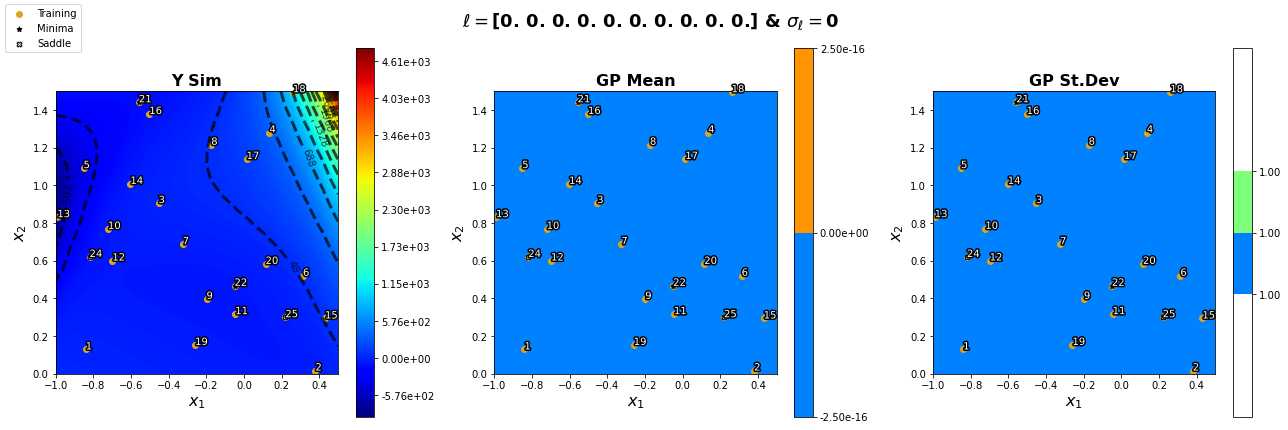

In [6]:
#Plot GP Predictions and True value
title = ["Y Sim", "GP Mean", "GP St.Dev"]
z = [y_sim.T, GP_mean.T, GP_stdev.T]
#Not sure how to find stdev of the lengthscale
Muller_plotter(X_mesh, z, minima, saddle, title, set_lengthscale, train_iter, t, CS, Bound_Cut, 
               lenscl_final = lenscl_final, lenscl_noise_final = 0, kernel = "Mat 5/2", DateTime = None, X_train = Xexp, 
               save_csvs = False, save_figure = False, Mul_title = "", param = "", percentile = "", 
               tot_lev = [40,40,75])